## Initial Setup 
Import modules, load weights from pre-trained FCN, and set hyperparameters

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import nengo 
from nengo.dists import Choice 
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot
from nengo.neurons import Direct

import tensorflow as tf
import gym
import pickle

import pdb

In [2]:
dnn_weights = pickle.load(open('./Weights/DNN_weights.p', 'rb'))
dnn_layers = len(dnn_weights)
dnn_activations = pickle.load(open('./Weights/activations.p', 'rb'))

INPUT_DIMS = 4
OUTPUT_DIMS = 2
h = 64
T_INT = 0.50
CLOCK = 1000.00 #Hz 
N_EPISODES = 10

## Tensorflow Model 
We'll build the SNN here using the previously learned weights to compare with our SNN. We'll also setup our environment model 

In [3]:
tf_model = {}
with tf.variable_scope('layer_one',reuse=False):
    xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(INPUT_DIMS), dtype=tf.float32)
    tf_model['W1'] = tf.get_variable("W1", [INPUT_DIMS, h], initializer=xavier_l1)
with tf.variable_scope('layer_two',reuse=False):
    xavier_l2 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(h), dtype=tf.float32)
    tf_model['W2'] = tf.get_variable("W2", [h,h], initializer=xavier_l2)
with tf.variable_scope('layer_1',reuse=False):
    xavier_l3 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(h), dtype=tf.float32)
    tf_model['W3'] = tf.get_variable("W3", [h,OUTPUT_DIMS], initializer=xavier_l3)

In [4]:
def tf_policy_forward(x): #x ~ [1,D]
    h = tf.matmul(x, tf_model['W1'])
    h = tf.nn.relu(h)
    h = tf.matmul(h, tf_model['W2'])
    h = tf.nn.relu(h)
#     p = tf.matmul(h, tf_model['W3'])
    logp = tf.matmul(h, tf_model['W3'])
    p = tf.nn.softmax(logp)
    return p #normalized logits

def softmax(x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

tf_x = tf.placeholder(dtype=tf.float32, shape=[None, INPUT_DIMS],name="tf_x")
tf_aprob = tf_policy_forward(tf_x)

saver = tf.train.Saver()
sess = tf.InteractiveSession()
saver.restore(sess, './Weights/weights')

env = gym.make('CartPole-v0')


[2017-06-10 11:37:42,565] Making new env: CartPole-v0


## Weight Normalization 
Using Data-based normalization (Diehl et al), scale weights based on maximum activation and maximum weight per-layer. Maximum input to a neuron should result in a rate of no more than the clock rate. 

In [5]:
previous_factor = 1.0
scaled_weights = []
for layer, weight in enumerate(dnn_weights[:2]):
    max_act = np.amax(dnn_activations[layer])
    max_wt = np.amax(weight)
    scale_factor = np.max((max_act, max_wt))/CLOCK
    applied_factor = scale_factor/previous_factor
    scaled_weights.append(weight/applied_factor)
    previous_factor = scale_factor 
scaled_weights.append(dnn_weights[2]*previous_factor)

## Weight Distribution 
We plot the weights of each layer for inspection. Notice the majority of weights are near zero. This will mainfest as sparsity in the spike trains later

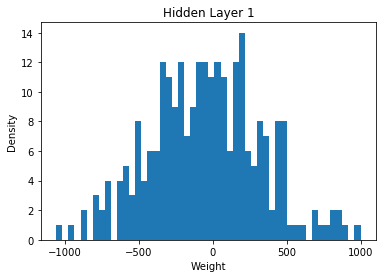

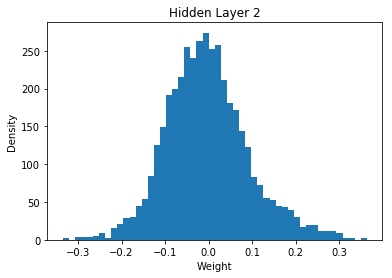

In [6]:
plt.hist(scaled_weights[0].flatten(), bins= 50)
plt.xlabel('Weight')
plt.ylabel('Density')
plt.title('Hidden Layer 1')
plt.show()

plt.figure()
plt.hist(scaled_weights[1].flatten(), bins= 50)
plt.xlabel('Weight')
plt.ylabel('Density')
plt.title('Hidden Layer 2')
plt.show()

## ReLU Network
We'll build a network using the scaled weights calculated previously and ReLU neurons to validate the weight scaling. 

In [7]:
model = nengo.Network()

model_layers = {}
with model: 
    for layer, weight in enumerate(scaled_weights):
        no_neuron = weight.shape[1]
        model_layers[layer] = nengo.Ensemble(no_neuron, 
                                             dimensions=no_neuron,
                                             neuron_type = nengo.RectifiedLinear(),
                                             encoders= np.eye(no_neuron),
                                             max_rates = np.zeros([no_neuron,]) + 1.0,
                                             intercepts = np.zeros([no_neuron,])
                                             )
    model_layers[0].label = 'Layer 1'
    model_layers[1].label = 'Layer 2'
    model_layers[2].label = 'Layer 3' #Not in use 
    
    input_node = nengo.Node(lambda t: observation, size_out=INPUT_DIMS) 
    nengo.Connection(input_node, model_layers[0], 
                     transform=scaled_weights[0].transpose(),
                    synapse = 0.001)
    nengo.Connection(model_layers[0].neurons, model_layers[1], 
                     transform=scaled_weights[1].transpose(),
                    synapse = 0.01)
    nengo.Connection(model_layers[1].neurons, model_layers[2], 
                     transform=scaled_weights[2].transpose(),
                    synapse = 0.001)
    
    Probe_In = nengo.Probe(input_node)
    Probe_A1 = nengo.Probe(model_layers[2].neurons[0], synapse = 0.01)
    Probe_A2 = nengo.Probe(model_layers[2].neurons[1], synapse = 0.01)
    Probe = nengo.Probe(model_layers[0].neurons)
    Probe_in2 = nengo.Probe(model_layers[1], 'input')
    Spikes_1 = nengo.Probe(model_layers[0].neurons)
    Spikes_2 = nengo.Probe(model_layers[1].neurons, synapse = 0.03)
    Spikes_3 = nengo.Probe(model_layers[2].neurons)

In [8]:
error = []
epsd_error = []
for epsd in range(N_EPISODES):
    observation = env.reset()
    done = False
    epsd_err = []
    while not done:
        x = observation
        feed = {tf_x: np.reshape(x, (1,-1))}
        aprob = sess.run(tf_aprob,feed)
        dnn_aprob = aprob[0,:]      
        with nengo.Simulator(model) as sim:
            sim.run(T_INT, progress_bar=False)
        h_out = sim.data[Spikes_1]
        out_enc = sim.data[Spikes_2]
        out_dec = np.dot(out_enc,scaled_weights[2])
        n = out_dec.shape[0]
        out_1 = out_dec[n-100:,0].mean()
        out_2 = out_dec[n-100:,1].mean()
        snn_aprob = softmax([out_1,out_2])
        action = np.random.choice(OUTPUT_DIMS, p=snn_aprob)
        observation, reward, done, info = env.step(action)
        err = dnn_aprob[0]-snn_aprob[0]
        error.append(err)
        epsd_err.append(err)
    if not epsd % 1:
        print('Episode %r complete' % (epsd))
    eps_RMSE = np.sqrt(np.mean(np.array(epsd_err)**2))
    epsd_error.append(eps_RMSE)

Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.                                                                                           
Building finished in 0:00:01.   

RMSE is 8.5316843119516172e-08


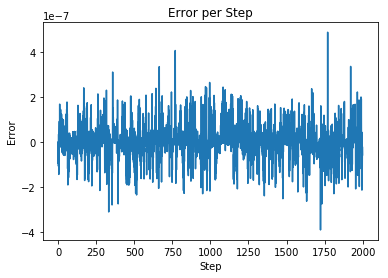

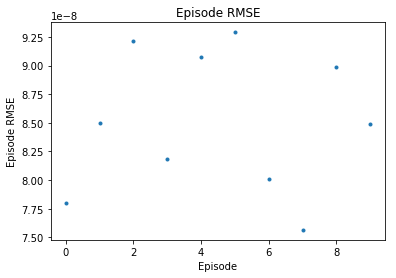

In [9]:
RMSE = np.sqrt(np.mean(np.array(error)**2))
print('RMSE is %r' % RMSE)

plt.figure()
plt.plot(error)
plt.xlabel('Step')
plt.ylabel('Error')
plt.title('Error per Step')
plt.figure()
plt.plot(epsd_error, '.')
plt.xlabel('Episode')
plt.ylabel('Episode RMSE')
plt.title('Episode RMSE')
plt.show()

In [15]:
model = nengo.Network()

model_layers = {}
with model: 
    for layer, weight in enumerate(scaled_weights):
        no_neuron = weight.shape[1]
        model_layers[layer] = nengo.Ensemble(no_neuron, 
                                             dimensions=no_neuron,
                                             neuron_type = nengo.LIF(tau_rc = 10000, tau_ref=0.001),
                                             encoders= np.eye(no_neuron),
                                             max_rates = np.zeros([no_neuron,]) + 1.0,
                                             intercepts = np.zeros([no_neuron,])
                                             )
    model_layers[0].label = 'Layer 1'
    model_layers[1].label = 'Layer 2'
    model_layers[2].label = 'Layer 3' #Not in use 
    
    input_node = nengo.Node(lambda t: observation, size_out=INPUT_DIMS) 
    nengo.Connection(input_node, model_layers[0], 
                     transform=scaled_weights[0].transpose(),
                    synapse = 0.0005)
    nengo.Connection(model_layers[0].neurons, model_layers[1], 
                     transform=scaled_weights[1].transpose(),
                    synapse = 0.0005)
    nengo.Connection(model_layers[1].neurons, model_layers[2], 
                     transform=scaled_weights[2].transpose(),
                    synapse = 0.0005)
    
    Probe_In = nengo.Probe(input_node)
    Probe_A1 = nengo.Probe(model_layers[2].neurons[0], synapse = 0.01)
    Probe_A2 = nengo.Probe(model_layers[2].neurons[1], synapse = 0.01)
    Probe = nengo.Probe(model_layers[0].neurons)
    Probe_in2 = nengo.Probe(model_layers[1], 'input')
    Spikes_1 = nengo.Probe(model_layers[0].neurons)
    Spikes_2 = nengo.Probe(model_layers[1].neurons, synapse = 0.0005)
    Spikes_3 = nengo.Probe(model_layers[2].neurons)

Building finished in 0:00:01.                                                                   
Simulating finished in 0:00:01.                                                                 
observation: array([-0.03945757, -0.01503651, -0.01153954,  0.03617246])
dnn: array([ 0.28898945,  0.71101058], dtype=float32)
snn: array([ 0.31475764,  0.68524236])


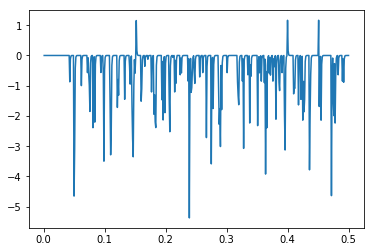

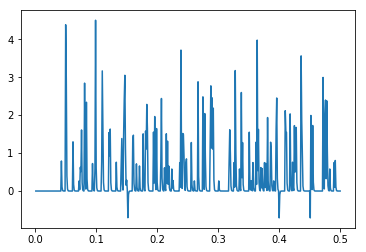

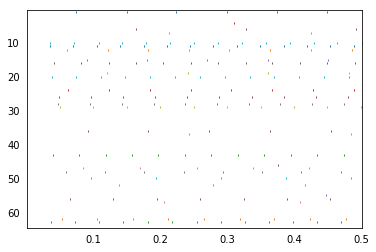

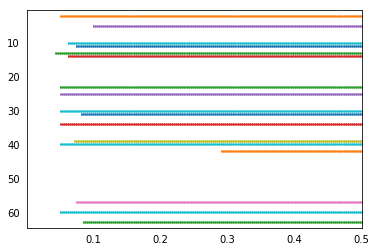

In [18]:
observation = env.reset()
x = observation
feed = {tf_x: np.reshape(x, (1,-1))}
aprob = sess.run(tf_aprob,feed)
dnn_aprob = aprob[0,:]      

with nengo.Simulator(model) as sim:
    sim.run(T_INT)
h_out = sim.data[Spikes_1]
out_enc = sim.data[Spikes_2]
out_dec = np.dot(out_enc,scaled_weights[2])
n = out_dec.shape[0]
out_1 = out_dec[25:,0].mean()
out_2 = out_dec[25:,1].mean()

snn_aprob = softmax([out_1,out_2])
print('observation: %r' % observation)
print('dnn: %r' % dnn_aprob)
print('snn: %r' % snn_aprob)

plt.close()
plt.plot(sim.trange(), out_dec[:,0])

plt.figure()
plt.plot(sim.trange(), out_dec[:,1])

plt.figure()
rasterplot(sim.trange(), h_out)

plt.figure()
rasterplot(sim.trange(), out_enc)

plt.show()



In [188]:
error = []
epsd_error = []
for epsd in range(N_EPISODES):
    observation = env.reset()
    done = False
    epsd_err = []
    while not done:
        x = observation
        feed = {tf_x: np.reshape(x, (1,-1))}
        aprob = sess.run(tf_aprob,feed)
        dnn_aprob = aprob[0,:]      
        with nengo.Simulator(model) as sim:
            sim.run(T_INT, progress_bar=False)
        h_out = sim.data[Spikes_1]
        out_enc = sim.data[Spikes_2]
        out_dec = np.dot(out_enc,scaled_weights[2])
        n = out_dec.shape[0]
        out_1 = out_dec[n-100:,0].mean()
        out_2 = out_dec[n-100:,1].mean()
        snn_aprob = softmax([out_1,out_2])
        action = np.random.choice(OUTPUT_DIMS, p=snn_aprob)
        observation, reward, done, info = env.step(action)
        err = dnn_aprob[0]-snn_aprob[0]
        error.append(err)
        epsd_err.append(err)
    if not epsd % 1:
        print('Episode %r complete' % (epsd))
    eps_RMSE = np.sqrt(np.mean(np.array(epsd_err)**2))
    epsd_error.append(eps_RMSE)

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Building finished in 0:00:01

RMSE is 0.033031960703526216
Mean Error -0.0033885925831862005
Error Standard Deviation 0.032857691157847285


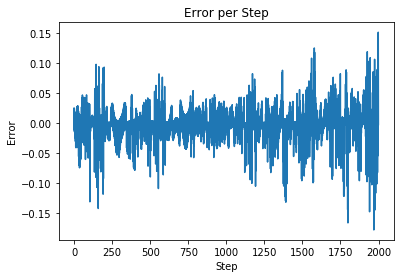

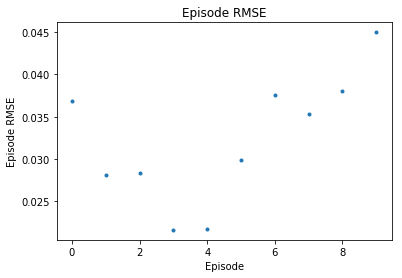

In [236]:
RMSE = np.sqrt(np.mean(np.array(error)**2))
print('RMSE is %r' % RMSE)
print('Mean Error %r' % np.mean(error))
print('Error Standard Deviation %r' % np.std(error))

plt.figure()
plt.plot(error)
plt.xlabel('Step')
plt.ylabel('Error')
plt.title('Error per Step')
plt.figure()
plt.plot(epsd_error, '.')
plt.xlabel('Episode')
plt.ylabel('Episode RMSE')
plt.title('Episode RMSE')
plt.show()